<a href="https://colab.research.google.com/github/Txart/OpenPNM-Examples/blob/master/cwl_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import scipy.sparse


# Set up domain
- Choose graph
- Set DEM

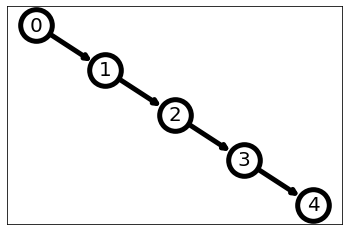

In [2]:
# Create array
def choose_graph(graph_name):
    if graph_name == 'line':
        graph = np.array([[0,0,0,0,0],
                         [1,0,0,0,0],
                         [0,1,0,0,0],
                         [0,0,1,0,0],
                         [0,0,0,1,0]])
        
    elif graph_name == 'ring':
        graph = np.array([[0,0,0,0,1],
                         [1,0,0,0,0],
                         [0,1,0,0,0],
                         [0,0,1,0,0],
                         [0,0,0,1,0]])

    elif graph_name == 'lollipop':
        graph = np.array([[0,0,0,0,0],
                             [1,0,0,0,0],
                             [1,0,0,0,0],
                             [0,1,1,0,0],
                             [0,0,0,1,0]])
    elif graph_name == 'grid':
        graph = np.array([[0,0,0,0,0,0,0,0,0,0,0,0],
                         [1,0,0,0,0,0,0,0,0,0,0,0],
                         [0,1,0,0,0,0,0,0,0,0,0,0],
                         [0,0,1,0,0,0,0,0,0,0,0,0],
                         [1,0,0,0,0,0,0,0,0,0,0,0],
                         [0,1,0,0,1,0,0,0,0,0,0,0],
                         [0,0,1,0,0,1,0,0,0,0,0,0],
                         [0,0,0,1,0,0,1,0,0,0,0,0],
                         [0,0,0,0,1,0,0,0,0,0,0,0],
                         [0,0,0,0,0,1,0,0,1,0,0,0],
                         [0,0,0,0,0,0,1,0,0,1,0,0],
                         [0,0,0,0,0,0,0,1,0,0,1,0]])
    return graph

"""
Choose graph
"""
cnm = choose_graph('line')

cnm_sim = cnm + cnm.T
#ini_values = np.array([10, 5, 5, 3, 2])
dem = np.arange(cnm.shape[0])[::-1]

CNM = scipy.sparse.csr_matrix(cnm) # In order to use the same sparse type as the big ass true adjacency matrix

n_edges = np.sum(CNM)
n_nodes = CNM.shape[0]

# Create NetworkX graph
g = nx.DiGraph(incoming_graph_data=CNM.T) # transposed for dynamics!

def initialize_graph_values(g, h_ini, dem_nodes, diri_bc_values, diri_bc_bool, neumann_bc_values, neumann_bc_bool, source):
    nx.set_node_attributes(G=g, values={i: value for i, value in enumerate(h_ini)}, name='h_old')
    nx.set_node_attributes(G=g, values={i: value for i, value in enumerate(h_ini)}, name='h_new')
    nx.set_node_attributes(G=g, values={i: value for i, value in enumerate(dem_nodes)}, name='ele')   
    nx.set_node_attributes(G=g, values={i: value for i, value in enumerate(diri_bc_values)}, name='diri_bc')
    nx.set_node_attributes(G=g, values={i: value for i, value in enumerate(diri_bc_bool)}, name='diri_bool')
    nx.set_node_attributes(G=g, values={i: value for i, value in enumerate(neumann_bc_values)}, name='neumann_bc')
    nx.set_node_attributes(G=g, values={i: value for i, value in enumerate(neumann_bc_bool)}, name='neumann_bool')
    nx.set_node_attributes(G=g, values={i: value for i, value in enumerate(source)}, name='source')
    
    return 0

g_un = nx.Graph(g) # symmetric matrix, undirected graph. Useful for dynamics    

# Plot
one_dim = True
if one_dim:
    pos = {node:pos for node, pos in enumerate(zip(np.arange(n_nodes), dem))}
else:
    pos = {i:((i%4), -int(i/4)) for i in range(0,12)}
options = {
    "font_size": 20,
    "node_size": 1000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 5,
    "width": 5,
}
nx.draw_networkx(g, pos=pos, **options)

In [3]:
# Functions

def infer_extreme_nodes(adj_matrix):
    """
    Infer what nodes are the beginning and end of canals from adjacency matrix.
    Last nodes of canals  are identified by having no outgoing edges
    First nodes of canals have no incoming edges

    Parameters
    ----------
    adj_matrix : numpy array
        Adjacency matrix of the canal network graph

    Returns
    -------
    end_nodes_bool : boolean numpy array
        True where nodes are last nodes of canals
    first_nodes_bool : boolean numpy array
        True where nodes are first nodes of canals

    """
    # Infer neumann and Diri nodes from adj matrix
    end_nodes_bool = np.sum(CNM, axis=0) == 0 # Boundary values below are conditional on this boolean mask
    first_nodes_bool = np.sum(CNM, axis=1) == 0 
    # in case the summing over the sparse matrix changes the numpy array shape
    end_nodes_bool = np.ravel(end_nodes_bool) 
    first_nodes_bool = np.ravel(first_nodes_bool)
   
    return first_nodes_bool, end_nodes_bool

def compute_laplacian_from_adjacency(adj_matrix):
    if np.any(adj_matrix != adj_matrix.T):
        raise ValueError('the matrix must be symmetric, i.e., must be the adj matrix of an undirected graph')
    degree_matrix = np.diag(np.sum(adj_matrix, axis=1))
    laplacian = degree_matrix - adj_matrix
    
    return laplacian

def L_advection(directed_adj_matrix):
    """
    Returns the 'modified Laplacian', i.e., the advection operator
    """
    D_out = np.diag(np.sum(directed_adj_matrix, axis=0))
    return D_out - directed_adj_matrix

def advection_diffusion_operator(dx, L, L_adv, a, b, diri_bc_bool, neumann_bc_upstream, neumann_bc_downstream, neumann_bc_values):
    
    # Set default BCs: Neumann
    L_BC = L.copy() # L doesn't change
    
    L_advBC = L_adv.copy()
    # Beginning nodes get a -1 in the diagonal
    L_advBC[neumann_bc_upstream, neumann_bc_upstream] = L[neumann_bc_upstream, neumann_bc_upstream] - 1
    
    # Ending nodes get a +1 in the diagonal
    L_advBC[neumann_bc_downstream, neumann_bc_downstream] = L[neumann_bc_downstream, neumann_bc_downstream] + 1    
    
    # Construct operator
    L_mix = a/dx**2*(-L_BC) - b/dx*L_advBC
    
    # Set Diri BCs
    L_mix[diri_bc_bool] = np.zeros(shape=L_mix[0].shape)
    
    return L_mix
    
def set_source_BC(source, dx, a, b, diri_bc_bool, neumann_bc_upstream, neumann_bc_downstream, neumann_bc_values):
    
    source_BC = np.array(source, dtype=float).copy()
    # Set Neumann BC. No-flux as default
    # Beginning nodes get an extra flux*(-a/dx + b)
    source_BC[neumann_bc_upstream] = source_BC[neumann_bc_upstream] + neumann_bc_values[neumann_bc_upstream]*(-a[neumann_bc_upstream]/dx + b[neumann_bc_upstream])
    
    # Ending nodes get an extra -flux*a/dx
    source_BC[neumann_bc_downstream] = source_BC[neumann_bc_downstream] - neumann_bc_values[neumann_bc_downstream]*a[neumann_bc_downstream]/dx    
    
    # Set Diri BC
    source_BC[diri_bc_bool] = 0.
    
    return source_BC


def forward_Euler_adv_diff_single_step(h, dt, L_mix, source): 
    return h + dt * L_mix @ h + dt*source


def backwards_Euler(h, dt, L_mix, source):
    
    P = np.eye(N=L_mix.shape[0]) - dt*L_mix
    P_inv = np.linalg.inv(P)
    
    h = P_inv @ (h + dt*source)
    
    return h


In [4]:
# Parameters
plotOpt = True
dx = 10
dt = 1
time_duration = 1000
niter = int(time_duration/dt)

a = 1 * np.ones(n_nodes)
b = 1 * np.ones(n_nodes)
if np.all(b < 0):
    cnm = cnm.T
elif np.prod(b <0):
    raise ValueError('Some but not all of bs are negative. Those digarph edge directions should be reversed!')

# General advection-diffusion PDE on graphs
The advection-diffusion PDE 
$$\frac{du}{dt} = au'' - bu' + source$$

with $b>0$ (i.e., the flow has the same direction as the edges) can be written in vectorial form in a directed graph like:
$$\frac{du}{dt} = -aLu - bL_{adv}u + source =\\ =L_{mix} u + source$$

The (strange) sign  convention chosen here is such that:
$$u'' = -Lu$$
$$u' = L_{adv}u,$$

This strange sign convention is chosen for 2 reasons:
1. Advection-=diffusion  eqs are usually written as $u_t = au'' - vu'$.

2. $L$ and $L_{adv}$ have already been defined in the literature, and we use the most common definitions. Those are:

$$ L = diag(d) - A $$
where $d_i$ is the total number of neighbors of noe $i$ and $diag(d)$ is the matrix with $d_i$ in the diagonals. $A$ is the adjacency matrix of the undirected graph.

$$ L_{adv} = diag(d_{out}) - A_{in}$$

where $d_{out}$ is the number of outgoing neighbours and $A_{in}$ is the incoming adjacency matrix.

## Connection to finite differences
### Connection to 1D
When the graph is a 1D line, the resulting Laplacian matrices are:
- $L$ is equivalent to (minus) the centered difference scheme (with Neumann BC if we apply upwind scheme to the boundary nodes). For example, with a line of 4 nodes: 
$$
L = \left(\matrix{
1 & -1 & 0 & 0 \cr
-1 & 2 & -1& 0 \cr
0 & -1 & 2 & -1\cr
0 & 0 & -1 & 1}\right)
$$

- $L_{adv}$ is the upwind scheme for the advection equation (https://en.wikipedia.org/wiki/Upwind_scheme):

$$
L_{adv} = \left(\matrix{
1 & 0 & 0 & 0 \cr
-1 & 1 & 0 & 0 \cr
0 & -1 & 1 & 0\cr
0 & 0 & -1 & 0}\right)
$$
This one has funnier BC, and they are so in two accounts:

First, since $b>0$, this represents a wave moving to the right, so in the 1D advection equation only  boundary conditions for the left boundary are needed. In all text I have seen, only diri BCs appear. Neumann BCs are not covered. If you try to append a ghost node and apply a fixed flux, it doesn't work. Diri BC is of course much easier to implement, so I'll stick with it.

Second, the rightmost boundary is effectively a no-flow boundary, since $u_4^{t+1} = u_4^t + u_3^t$, and that last node collects all that is incoming from the left. This is not what happens in the upwind scheme. There, the last row of the matrix reads $\left(0,0,-1,1\right)$. And, since no right BC are needed, this is usually left untouched.

In any way, what's important when modelling is to be practical adjust these finite difference schemes to what we want to model, so in practice other BC are possible.


### Connection to 2D 
- To do-




In [5]:
# Set up simulations
L = compute_laplacian_from_adjacency(cnm_sim)
L_adv = L_advection(cnm)
if np.all(b < 0):
    L_adv = -L_adv
elif np.prod(b <0):
    raise ValueError('Some but not all of bs are negative. Those digarph edge directions should be reversed!')

ini_values = dem
source = np.array([0]*n_nodes)
u = ini_values.copy()

diri_bc_bool = np.array([False]*n_nodes)
diri_bc_bool[0] = True
upstream_bool, downstream_bool = infer_extreme_nodes(cnm_sim)
neumann_bc_bool = np.array([False]*n_nodes)
neumann_bc_bool[-1] = True
neumann_bc_upstream = neumann_bc_bool * upstream_bool
neumann_bc_downstream = neumann_bc_bool * downstream_bool
neumann_bc_values = 0.001*neumann_bc_bool # General Neumann BC not implemented yet

if np.any(diri_bc_bool * neumann_bc_bool == True):
    raise ValueError('diri and neumann BC applied at the same time in some node')


L_mix = advection_diffusion_operator(dx, L, L_adv, a, b, diri_bc_bool, neumann_bc_upstream, neumann_bc_downstream, neumann_bc_values)
source_BC = set_source_BC(source, dx, a, b, diri_bc_bool, neumann_bc_upstream, neumann_bc_downstream, neumann_bc_values)

In [6]:
print('neumann: ',neumann_bc_upstream, neumann_bc_downstream, neumann_bc_values)
print('diri: ', diri_bc_bool)
print('source_BC: ', source_BC)
source_BC[neumann_bc_upstream]

np.any(diri_bc_bool == neumann_bc_bool)

neumann:  [False False False False False] [False False False False  True] [0.    0.    0.    0.    0.001]
diri:  [ True False False False False]
source_BC:  [ 0.      0.      0.      0.     -0.0001]


True

In [7]:
# Simulate
u_sol = [0]*niter
for t in range(niter):
    u_sol[t] = u
    u = forward_Euler_adv_diff_single_step(u, dt, L_mix, source_BC)
    


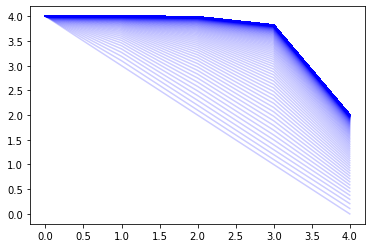

In [8]:
# Plot
%matplotlib inline
if one_dim:
    plt.figure()
    for t in range(niter):
        plt.plot(u_sol[t], color='blue', alpha=0.2)

else:
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    xs, ys = np.meshgrid(np.linspace(0,1, 4), np.linspace(0,1,3))
    ax.plot_surface(xs, ys, u_sol[1].reshape(3,4))
    ax.scatter(xs, ys, u_sol[1].reshape(3,4), color='orange')

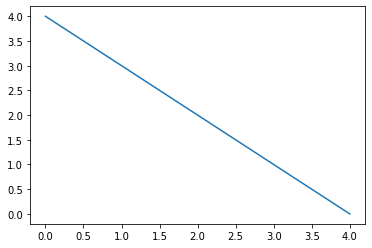

In [9]:
# Animations
%matplotlib inline
import matplotlib.animation as animation

if one_dim:
    fig, ax = plt.subplots()

    line, = ax.plot(u_sol[0], alpha=1.0)

    def animate(t):
        line.set_ydata(u_sol[t])  # update the data.
        return line,
    
    ani = animation.FuncAnimation(
    fig, animate)

else:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_zlim(0, 20)
    xs, ys = np.meshgrid(np.linspace(0,1, 4), np.linspace(0,1,3))

    plot = [ax.plot_surface(xs, ys, u_sol[0].reshape(3,4), color='1')]
    
    def animate(t, u_sol, plot):
        plot[0].remove()
        plot[0] = ax.plot_surface(xs, ys, u_sol[t].reshape(3,4), color='0.75')
        return plot[0],
    ani = animation.FuncAnimation(fig, animate, fargs=(u_sol,plot))

from IPython.display import HTML
HTML(ani.to_html5_video())

## Saint Venant: Diffusive wave

The diffusive wave approximation of the Saint-Venant equations is 

$$\frac{dQ}{dt} = D\frac{dQ^2}{d^2x} - \lambda \frac{dQ}{dx}$$

We use the Manning classical approximation for  $D$ and $\lambda$,

$$D = \frac{A^2 R^{4/3}}{2n^2B |Q|}$$
$$\lambda = \frac{5Q}{3A}$$

notice that both depend on $Q$ and $A$, so even in  the Diffusive wave approximation, St. Venants eqs are a system of non-linear coupled PDEs. $R = A/P$ is the hydraulic radius, where $P$ is the wetteed perimeter (the part of the canal wetted by the water). For rectangular channels, $R = YB/(2Y+B) = AB/(2A+B^2)$.

In order to know the water height from the canal bottom, $Y$, the mass conservation equation of the St. Venants eqs can be used:

$$ \frac{dA}{dt} = -\frac{dQ}{dx}$$

### Simplest numerical scheme

The usefullness of the Laplacian approach is most apparent when we use explicit forward Euler in time and treating the $Q$ and $A$ equations as a 2 step iterative process, so that when we solve for $Q$ we assume that $A$ is constant, and viceversa:

Simplest algorithm. At each timestep:
1. $$Q = f(Q^-, A^-)$$
2. $$A = g(A^-, Q)$$
3. $$Q^- \leftarrow Q; A^- \leftarrow A$$

where $Q^-$ stands for the value of $Q$ at the previous iteration.

The alternative is to use the implicit backwards Euler scheme and to solve the full set of coupled nonlinear algebraic equations using something like the Newton-Rhapson method, but this gets very messy very quickly and although the Laplacian formulation may help, it is not as useful anymore.

In [18]:
cnm = choose_graph('line').T # Advection is negative
cnm_sim = cnm + cnm.T
n_nodes = cnm.shape[0]
L = compute_laplacian_from_adjacency(cnm_sim)
L_adv = -L_advection(cnm) #Advection is negative

upstream_bool, downstream_bool = infer_extreme_nodes(cnm_sim)

# params
B = 7 # (rectangular) canal width in m
n_manning = 2.
dx = 100
dt = 0.1

# Q stuff
Q_ini = np.arange(1,n_nodes+1,1)
Q_source = np.zeros(n_nodes)
Q = Q_ini.copy()
Q_diri_bc_bool = np.array([False]*n_nodes)
#Q_diri_bc_bool[-1] = True
Q_neumann_bc_bool = np.array([False]*n_nodes)
Q_neumann_bc_values = 0*Q_neumann_bc_bool # General Neumann BC not implemented yet
Q_neumann_bc_upstream = Q_neumann_bc_bool * upstream_bool
Q_neumann_bc_downstream = Q_neumann_bc_bool * downstream_bool

# A stuff
Y_ini = np.ones(n_nodes) # m above canal bottom
A_ini = Y_ini * B 
A = A_ini.copy()
A_diri_bc_bool = np.array([False]*n_nodes)
A_neumann_bc_bool = np.array([False]*n_nodes)
A_neumann_bc_values = 0*A_neumann_bc_bool # General Neumann BC not implemented yet
A_neumann_bc_upstream = A_neumann_bc_bool * upstream_bool
A_neumann_bc_downstream = A_neumann_bc_bool * downstream_bool
#A_diri_bc_bool[-1] = True
A_source = np.zeros(n_nodes)

def diffusion_coeff(A, Q, B, n_manning):
  return A**2 * (A*B/(2*A + B**2)**(4/3))/(2*n_manning**2 * B * Q)

def advection_coeff(A, Q):
  return 5/3 * Q/A

D = diffusion_coeff(A, Q, B, n_manning)
l = advection_coeff(A, Q)

#L_mix = advection_diffusion_operator(dx, L, L_adv, D, -l, diri_bc_bool, neumann_bc_bool)
Q_L_mix = advection_diffusion_operator(dx, L, L_adv, D, -l, Q_diri_bc_bool, Q_neumann_bc_upstream, Q_neumann_bc_downstream, Q_neumann_bc_values)
A_L_mix = advection_diffusion_operator(dx, L, L_adv, np.zeros(n_nodes), np.ones(n_nodes), A_diri_bc_bool, A_neumann_bc_upstream, A_neumann_bc_downstream, A_neumann_bc_values)

# Simulate
Q_sol = [0]*niter
Y_sol = [0]*niter
for t in range(niter):
    D = diffusion_coeff(A, Q, B, n_manning)
    l = advection_coeff(A, Q)
        
    Q_source_BC = set_source_BC(Q_source, dx, D, -l, Q_diri_bc_bool, Q_neumann_bc_upstream, Q_neumann_bc_downstream, Q_neumann_bc_values)
    A_source_BC = set_source_BC(A_source, dx, np.zeros(n_nodes), np.ones(n_nodes), A_diri_bc_bool, A_neumann_bc_upstream, A_neumann_bc_downstream, A_neumann_bc_values)
    
    Q_sol[t] = Q; Y_sol[t] = A/B
    
    Q = Q + dt*Q_L_mix @ Q
    A = A + dt*A_L_mix@Q
    


In [19]:
A_L_mix


array([[-0.  , -0.01,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.01, -0.01,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.01, -0.01,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.01, -0.01],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.01]])

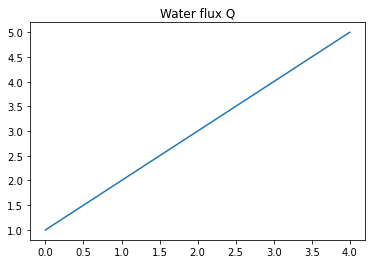

In [20]:
# Animate Q
figQ, axQ = plt.subplots()
axQ.set_title("Water flux Q")

lin, = axQ.plot(Q_sol[0], alpha=1.0)

def animate_Q(t):
    lin.set_ydata(Q_sol[t])  # update the data.
    return lin,

aniQ = animation.FuncAnimation(
figQ, animate_Q)
HTML(aniQ.to_html5_video())





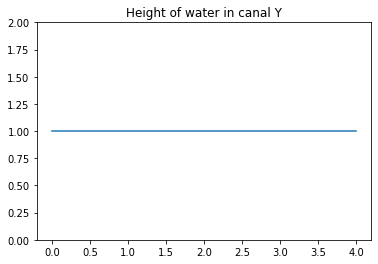

In [21]:
# Animate Y
figY, axY = plt.subplots()
axY.set_title("Height of water in canal Y")
axY.set_ylim(0,2)

lin, = axY.plot(Y_sol[0], alpha=1.0)

def animate_Y(t):
    lin.set_ydata(Y_sol[t])  # update the data.
    return lin,

aniY = animation.FuncAnimation(
figY, animate_Y)
HTML(aniY.to_html5_video())

## Full St Venant

Equations can be written (for a rectangular channel) as:

$$
\frac{\partial A}{\partial t} = -\frac{\partial Q}{\partial x} - q
$$

$$
\frac{\partial Q}{\partial t} = -2\frac{Q}{A}\frac{\partial Q}{\partial x} + \left(\frac{Q^2}{A^2} - \frac{gA}{B}\right)\frac{\partial A}{\partial x} + (S_0 - S_f)gA
$$

where $S_f$ is the friction slope. In the classical approximation by Manning it is given by

$$S_f = \frac{n^2 Q^2}{A^2 R^{4/3}}$$

Once again, the numerical scheme implemented here is the same as above: First compute Q, then A, both independently, and iterate.

### Steady state
Ini cond from initial state of Q and A

$$
\frac{\partial Q}{\partial x} =  - q
$$

Substitute that eq in the 2nd

$$
 2\frac{Qq}{A} + \left(\frac{Q^2}{A^2} - \frac{gA}{B}\right)\frac{\partial A}{\partial x} + (S_0 - S_f)gA
$$

And in terms of $L_{adv}$:
$$
 \left[-\left(\frac{Q^2}{A^2} - \frac{gA}{B}\right)L_{adv} + (S_0 - S_f)g I\right]A = - 2\frac{Qq}{A}
$$

NOTE
- 1st eq: if q = 0, then there is no gradient in Q, i.e., Q is a constant vector.
- 2nd eq: Invert matrix to get $A^2$. Iteratively. If q = 0 or Q = 0, then A is a constant vector too.

In [24]:
raise RuntimeError('Not updated for new BC handling yet')
cnm = choose_graph('line').T # Advection is negative
cnm_sim = cnm + cnm.T
n_nodes = cnm.shape[0]
L = compute_laplacian_from_adjacency(cnm_sim)
L_adv = -L_advection(cnm) #Advection is negative
S0 = dem[::-1] + 0.1 # Bottom elevation, i.e., DEM

# params
B = 7 # (rectangular) canal width in m
n_manning = 2.
dx = 100
dt = 0.01
q = 1 * np.ones(n_nodes) # lateral flow towards canal, source term for A eq

# Solve Q from 1st St. Venant eqs. 
Q,_,_,_ = np.linalg.lstsq(L_adv, q) # Instead of inverting L_adv, because it usually is a singular matrix

# A stuff
A_ini = np.ones(n_nodes)
A_squared = A_ini.copy()

# Solve ss Q from 1st St. Venant eqs. 
Q,_,_,_ = np.linalg.lstsq(L_adv, q, rcond=1e-7) # Instead of inverting L_adv, because it usually is a singular matrix

# Solve steady state A from 2nd St.Venants
A_sol = [0]*niter

for t in range(niter):
    A_sol[0] = np.sqrt(A_squared)
    R = A_squared*B/(2*A_squared + B**2)
    Sf = n_manning**2 * Q**2/(A_squared**2)/R**(4/3)
    matrix = ((Q**2/A_squared**2 - 9.8*A_squared/B)*L_adv + (S0 - Sf)*9.8* np.eye(n_nodes))
    
    A_squared, _, _, _ = np.linalg.lstsq(matrix, 2*Q*q)

RuntimeError: ignored

### Unsteady


In [30]:
cnm = choose_graph('line').T # Advection is negative
cnm_sim = cnm + cnm.T
n_nodes = cnm.shape[0]
L = compute_laplacian_from_adjacency(cnm_sim)
L_adv = -L_advection(cnm) #Advection is negative
S0 = ini_values[::-1] # Bottom elevation, i.e., DEM

# params
B = 7 # (rectangular) canal width in m
n_manning = 2.
dx = 100
dt = 0.01

# Q stuff
Q_ini = np.arange(1,n_nodes+1,1)

Q_source = np.zeros(n_nodes)
Q = Q_ini.copy()
Q_diri_bc_bool = np.array([False]*n_nodes)
#Q_diri_bc_bool[-1] = True
Q_neumann_bc_bool = np.array([False]*n_nodes)
Q_neumann_bc_values = 0*Q_neumann_bc_bool # General Neumann BC not implemented yet
Q_neumann_bc_upstream = Q_neumann_bc_bool * upstream_bool
Q_neumann_bc_downstream = Q_neumann_bc_bool * downstream_bool

# Parameters chosen so that L_adv_BC below is nothing but L_adv with correct BC downstream
L_adv_BC = advection_diffusion_operator(dx, L, L_adv, 0, 1, Q_diri_bc_bool, Q_neumann_bc_upstream, Q_neumann_bc_downstream, Q_neumann_bc_values)

# A stuff
Y_ini = np.ones(n_nodes) # m above canal bottom
A_ini = Y_ini * B 
A = A_ini.copy()
A_diri_bc_bool = np.array([False]*n_nodes)
A_neumann_bc_bool = np.array([False]*n_nodes)
A_neumann_bc_values = 0*A_neumann_bc_bool # General Neumann BC not implemented yet
A_neumann_bc_upstream = A_neumann_bc_bool * upstream_bool
A_neumann_bc_downstream = A_neumann_bc_bool * downstream_bool
#A_diri_bc_bool[-1] = True


# Simulate
Q_sol = [0]*niter
Y_sol = [0]*niter
for t in range(niter):
    print(t)
    
    Q_source_BC = set_source_BC(Q_source, dx, D, -l, Q_diri_bc_bool, Q_neumann_bc_upstream, Q_neumann_bc_downstream, Q_neumann_bc_values)
    A_source_BC = set_source_BC(A_source, dx, np.zeros(n_nodes), -np.ones(n_nodes), A_diri_bc_bool, A_neumann_bc_upstream, A_neumann_bc_downstream, A_neumann_bc_values)
    
    Q_sol[t] = Q; Y_sol[t] = A/B
    
    R = A*B/(2*A + B**2)
    Sf = n_manning**2 * Q**2/(A**2)/R**(4/3)
    
    Q = Q + dt*( 2*Q/A * L_adv@Q - (Q**2/A**2 - 9.8*A/B)*L_adv@A + (S0 - Sf)*9.8*A) 
    A = A + dt*(L_adv@Q + A_source_BC)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818


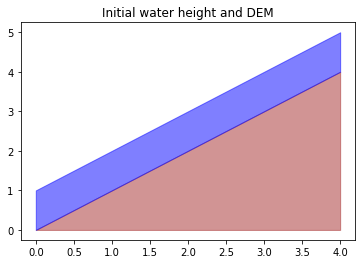

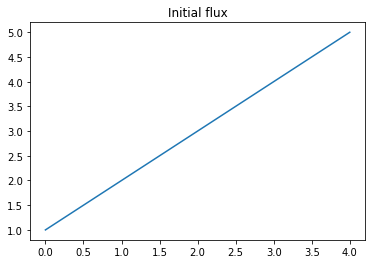

In [31]:
# Plot initial water height
plt.figure()
plt.fill_between(np.arange(n_nodes), y1=S0, y2=0, color='brown', alpha=0.5)
plt.fill_between(np.arange(n_nodes), y1=S0+Y_ini, y2=S0, color='blue', alpha=0.5)
plt.title('Initial water height and DEM')

plt.figure()
plt.plot(Q_ini)
plt.title('Initial flux')
plt.show()

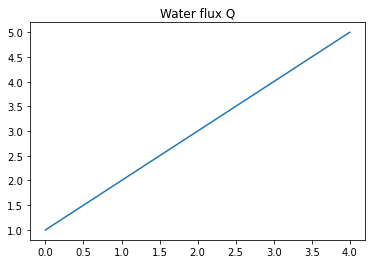

In [32]:
# Animate Q
figQ, axQ = plt.subplots()
axQ.set_title("Water flux Q")

lin, = axQ.plot(Q_sol[0], alpha=1.0)

def animate_Q(t):
    lin.set_ydata(Q_sol[t])  # update the data.
    return lin,

aniQ = animation.FuncAnimation(
figQ, animate_Q)
HTML(aniQ.to_html5_video())


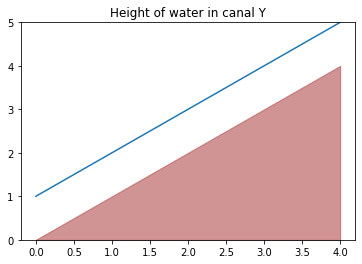

In [33]:
# Animate Y
figY, axY = plt.subplots()
axY.set_title("Height of water in canal Y")
axY.set_ylim(0,5)
axY.fill_between(np.arange(n_nodes), y1=S0, y2=0, color='brown', alpha=0.5)

lin, = axY.plot(S0 + Y_sol[0], alpha=1.0)

def animate_Y(t):
    lin.set_ydata(S0 + Y_sol[t])  # update the data.
    return lin,

aniY = animation.FuncAnimation(
figY, animate_Y)
HTML(aniY.to_html5_video())

In [ ]:
Q_sol


[array([1., 1., 1., 1., 1.]),
 array([1.60913718, 1.60770861, 2.29370861, 2.97970861, 2.97828004]),
 array([2.09839462, 2.09624203, 3.25980274, 4.3367984 , 4.3171885 ]),
 array([2.45323323, 2.45057947, 3.81578648, 4.90800986, 4.84320932]),
 array([2.69122674, 2.68539864, 4.07077821, 5.05562662, 4.93996742]),
 array([2.84376805, 2.83060999, 4.17233125, 5.07732139, 4.91905235]),
 array([2.94062065, 2.91682629, 4.21143649, 5.07096956, 4.87559962]),
 array([3.00372438, 2.96750506, 4.22770672, 5.05881652, 4.82865866]),
 array([3.04724366, 2.9979067 , 4.23590106, 5.04541465, 4.78156289]),
 array([3.07967931, 3.01708035, 4.24119428, 5.03167687, 4.73486611]),
 array([3.1059333 , 3.03012486, 4.24536263, 5.01778799, 4.68865456]),
 array([3.1287723 , 3.03983518, 4.24901262, 5.00378785, 4.64293817]),
 array([3.14974042, 3.04772114, 4.25235216, 4.98968737, 4.59771471]),
 array([3.16969469, 3.05459225, 4.25545362, 4.97549165, 4.55298006]),
 array([3.18910948, 3.06088091, 4.25834328, 4.9612045 , 4.50